In [ ]:
# default_exp plots

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_1300872/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Plotting Playing Sequence </center></h1>

This module is highly inspired from [`matplotsoccer` library](https://github.com/TomDecroos/matplotsoccer/blob/master/matplotsoccer/fns.py) with some bug fixes and improvements

# Config

In [ ]:
# export

import itertools
import math
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Arc
from matplotlib.pyplot import cm
from fastcore.basics import *
from fastcore.foundation import *

SPADL_CONFIG = {
    "length": 105,
    "width": 68,
    "penalty_box_length": 16.5,
    "penalty_box_width": 40.3,
    "six_yard_box_length": 5.5,
    "six_yard_box_width": 18.3,
    "penalty_spot_distance": 11,
    "goal_width": 7.3,
    "goal_length": 2,
    "origin_x": 0,
    "origin_y": 0,
    "circle_radius": 9.15,
}

ZLINE = 8000
ZFIELD = -5000
ZACTION = 9000

In [ ]:
data_path = "./data"
target_data = pickle.load(open(os.path.join(data_path, "targets.pkl"), "rb"))
labels = L(target_data.values()).unique()
df_main = pd.read_pickle(os.path.join(data_path, "sequences_df.pkl")).reset_index()
lbl2ids = {l: L(k for k, v in target_data.items() if v == l) for l in labels}

# Pitch

In [ ]:
# export


def _plot_rectangle(x1, y1, x2, y2, ax, color):
    ax.plot([x1, x1], [y1, y2], color=color, zorder=ZLINE)
    ax.plot([x2, x2], [y1, y2], color=color, zorder=ZLINE)
    ax.plot([x1, x2], [y1, y1], color=color, zorder=ZLINE)
    ax.plot([x1, x2], [y2, y2], color=color, zorder=ZLINE)


def _field(
    ax=None,
    fig=None,
    linecolor="black",
    fieldcolor="white",
    alpha=1,
    figsize=None,
    field_config=SPADL_CONFIG,
):
    cfg = field_config

    # Create figure
    if fig is None:
        fig, ax = plt.subplots()

    # Pitch Outline & Centre Line
    x1, y1, x2, y2 = (
        cfg["origin_x"],
        cfg["origin_y"],
        cfg["origin_x"] + cfg["length"],
        cfg["origin_y"] + cfg["width"],
    )

    d = cfg["goal_length"]
    rectangle = plt.Rectangle(
        (x1 - 2 * d, y1 - 2 * d),
        cfg["length"] + 4 * d,
        cfg["width"] + 4 * d,
        fc=fieldcolor,
        alpha=alpha,
        zorder=ZFIELD,
    )
    ax.add_patch(rectangle)
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)
    ax.plot([(x1 + x2) / 2, (x1 + x2) / 2], [y1, y2], color=linecolor, zorder=ZLINE)

    # Left Penalty Area
    x1 = cfg["origin_x"]
    x2 = cfg["origin_x"] + cfg["penalty_box_length"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["penalty_box_width"] / 2
    y2 = m + cfg["penalty_box_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Right Penalty Area
    x1 = cfg["origin_x"] + cfg["length"] - cfg["penalty_box_length"]
    x2 = cfg["origin_x"] + cfg["length"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["penalty_box_width"] / 2
    y2 = m + cfg["penalty_box_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Left 6-yard Box
    x1 = cfg["origin_x"]
    x2 = cfg["origin_x"] + cfg["six_yard_box_length"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["six_yard_box_width"] / 2
    y2 = m + cfg["six_yard_box_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Right 6-yard Box
    x1 = cfg["origin_x"] + cfg["length"] - cfg["six_yard_box_length"]
    x2 = cfg["origin_x"] + cfg["length"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["six_yard_box_width"] / 2
    y2 = m + cfg["six_yard_box_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Left Goal
    x1 = cfg["origin_x"] - cfg["goal_length"]
    x2 = cfg["origin_x"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["goal_width"] / 2
    y2 = m + cfg["goal_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Right Goal
    x1 = cfg["origin_x"] + cfg["length"]
    x2 = cfg["origin_x"] + cfg["length"] + cfg["goal_length"]
    m = (cfg["origin_y"] + cfg["width"]) / 2
    y1 = m - cfg["goal_width"] / 2
    y2 = m + cfg["goal_width"] / 2
    _plot_rectangle(x1, y1, x2, y2, ax=ax, color=linecolor)

    # Prepare Circles
    mx, my = (cfg["origin_x"] + cfg["length"]) / 2, (cfg["origin_y"] + cfg["width"]) / 2
    centreCircle = plt.Circle(
        (mx, my), cfg["circle_radius"], color=linecolor, fill=False, zorder=ZLINE
    )
    centreSpot = plt.Circle((mx, my), 0.4, color=linecolor, zorder=ZLINE)

    lx = cfg["origin_x"] + cfg["penalty_spot_distance"]
    leftPenSpot = plt.Circle((lx, my), 0.4, color=linecolor, zorder=ZLINE)
    rx = cfg["origin_x"] + cfg["length"] - cfg["penalty_spot_distance"]
    rightPenSpot = plt.Circle((rx, my), 0.4, color=linecolor, zorder=ZLINE)

    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    # Prepare Arcs
    r = cfg["circle_radius"] * 2
    leftArc = Arc(
        (lx, my),
        height=r,
        width=r,
        angle=0,
        theta1=307,
        theta2=53,
        color=linecolor,
        zorder=ZLINE,
    )
    rightArc = Arc(
        (rx, my),
        height=r,
        width=r,
        angle=0,
        theta1=127,
        theta2=233,
        color=linecolor,
        zorder=ZLINE,
    )

    # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    ## Tidy Axes
    ax.axis("off")

    # Display Pitch
    if figsize:
        h, w = fig.get_size_inches()
        ##newh, neww = figsize, w / h * figsize
        newh, neww = figsize, 68/105 * figsize
        fig.set_size_inches(newh, neww, forward=True)

    return fig, ax


def field(color="white", figsize=None, fig=None, ax=None):
    """
    Plot football pitch in different colors

    Parameters
    ----------
    color: str
        Current options are `white` or `green`
    figsize: int
        figure size in inches
    ax: matplotlib.axis
        the matplotlib.axis to update
    show: bool
        Should we call the `.show()` method on the created plot.

    Returns
    -------
    matplotlib.axis
        The pitch attached to a matplotlib.axis


    """
    if color == "white":
        return _field(
            fig=fig,
            ax=ax,
            linecolor="black",
            fieldcolor="white",
            alpha=1,
            figsize=figsize,
            field_config=SPADL_CONFIG,
        )
    elif color == "green":
        return _field(
            fig=fig,
            ax=ax,
            linecolor="white",
            fieldcolor="green",
            alpha=0.4,
            figsize=figsize,
            field_config=SPADL_CONFIG,
        )
    else:
        raise Exception("Invalid field color")

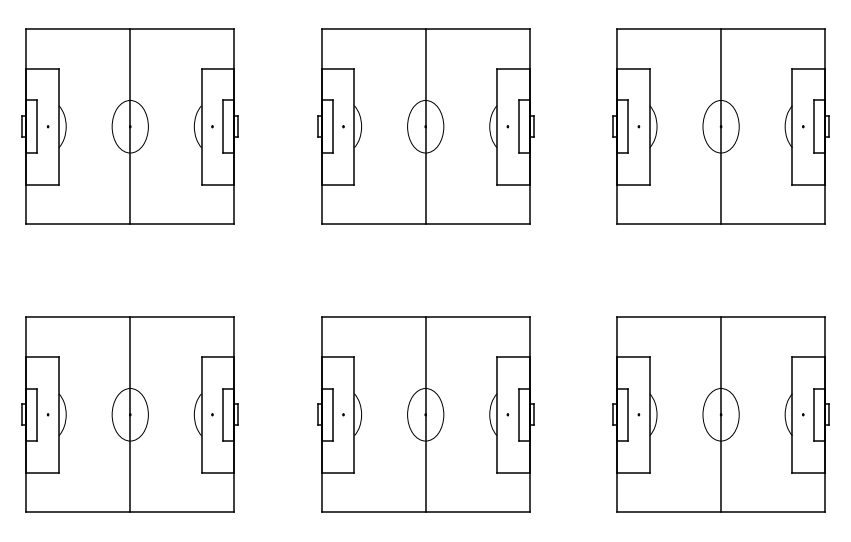

In [ ]:
from fastai.vision.all import *

fig, ctxs = get_grid(n=6, nrows=2, ncols=3, figsize=(15, 10), return_fig=True)
for i, ctx in enumerate(ctxs):
    field(color="white", figsize=15, fig=fig, ax=ctx)

# Actions

In [ ]:
# export


def get_lines(labels):
    labels = np.asarray(labels)
    if labels.ndim == 1:
        labels = labels.reshape(-1, 1)
    assert labels.ndim == 2

    labels = list([list([str(l) for l in ls]) for ls in labels])
    maxlen = {i: 0 for i in range(len(labels[0]))}
    for ls in labels:
        for i, l in enumerate(ls):
            maxlen[i] = max(maxlen[i], len(l))

    labels = [[l.ljust(maxlen[i]) for i, l in enumerate(ls)] for ls in labels]

    return [" | ".join(ls) for ls in labels]


def plot_actions(
    location,
    action_type=None,
    result=None,
    team=None,
    label=None,
    labeltitle=None,
    color="white",
    fig=None,
    ax=None,
    figsize=None,
    zoom=False,
    show_legend=True,
    return_fig=False,
):
    """Plot SPADL actions on a football pitch"""

    fig, ax = field(ax=ax, fig=fig, color=color, figsize=figsize)
    figsize, _ = fig.get_size_inches()
    arrowsize = math.sqrt(figsize)

    # SANITIZING INPUT
    location = np.asarray(location)

    if action_type is None:
        m, n = location.shape
        action_type = ["pass" for i in range(m)]
        if label is None:
            show_legend = False
    action_type = np.asarray(action_type)

    if team is None:
        team = ["Team X" for t in action_type]
    team = np.asarray(team)
    assert team.ndim == 1

    if result is None:
        result = [1 for t in action_type]
    result = np.asarray(result)
    assert result.ndim == 1

    if label is None:
        label = [t for t in action_type]
    label = np.asarray(label)
    lines = get_lines(label)

    if label is None:
        label = [[t] for t in action_type]
    label = np.asarray(label)
    if label.ndim == 1:
        label = label.reshape(-1, 1)
    assert label.ndim == 2

    indexa = np.asarray([list(range(1, len(label) + 1))]).reshape(-1, 1)
    label = np.concatenate([indexa, label], axis=1)
    if labeltitle is not None:
        labeltitle = list(labeltitle)
        labeltitle.insert(0, "")
        labeltitle = [labeltitle]
        label = np.concatenate([labeltitle, label])
        lines = get_lines(label)
        titleline = lines[0]
        ax.plot(np.NaN, np.NaN, "-", color="none", label=titleline)
        ax.plot(np.NaN, np.NaN, "-", color="none", label="-" * len(titleline))
        lines = lines[1:]
    else:
        lines = get_lines(label)

    m, n = location.shape
    if n != 2 and n != 4:
        raise ValueError("Location must have 2 or 4 columns")
    if n == 2:
        loc_end = location.copy()
        loc_end[:-1, :] = loc_end[1:, :]
        location = np.concatenate([location, loc_end], axis=1)
    assert location.shape[1] == 4

    text_offset = 3
    if zoom:
        x = np.concatenate([location[:, 0], location[:, 2]])
        y = np.concatenate([location[:, 1], location[:, 3]])
        xmin = min(x)
        xmax = max(x)
        ymin = min(y)
        ymax = max(y)
        mx = (xmin + xmax) / 2
        dx = (xmax - xmin) / 2
        my = (ymin + ymax) / 2
        dy = (ymax - ymin) / 2
        if type(zoom) == bool:
            d = max(dx, dy)
        else:
            d = zoom

        text_offset = 0.07 * d

        zoompad = 5

        xmin = max(mx - d, 0) - zoompad
        xmax = min(mx + d, spadl_config["length"]) + zoompad
        ax.set_xlim(xmin, xmax)
        ymin = max(my - d, 0) - zoompad
        ymax = min(my + d, spadl_config["width"]) + zoompad
        ax.set_ylim(ymin, ymax)

        h, w = fig.get_size_inches()
        h, w = xmax - xmin, ymax - ymin
        newh, neww = figsize, w / h * figsize

        fig.set_size_inches(newh, neww, forward=True)
        arrowsize = (w + h) / 2 / 105 * arrowsize

    eventmarkers = itertools.cycle(["s", "p", "h"])
    event_types = set(action_type)
    eventmarkerdict = {"pass": "o"}
    for eventtype in event_types:
        if eventtype != "pass":
            eventmarkerdict[eventtype] = next(eventmarkers)

    markersize = figsize

    def get_color(type_name, te):
        home_team = team[0]
        if type_name == "dribble":
            return "black"
        elif te == home_team:
            return "blue"
        else:
            return "red"

    colors = np.array([get_color(ty, te) for ty, te in zip(action_type, team)])
    blue_n = np.sum(colors == "blue")
    red_n = np.sum(colors == "red")
    blue_markers = iter(list(cm.Blues(np.linspace(0.1, 0.8, blue_n))))
    red_markers = iter(list(cm.Reds(np.linspace(0.1, 0.8, red_n))))

    cnt = 1
    for ty, r, loc, color, line in zip(action_type, result, location, colors, lines):
        [sx, sy, ex, ey] = loc
        ax.text(sx + text_offset, sy, str(cnt))
        cnt += 1
        if color == "blue":
            c = next(blue_markers)
        elif color == "red":
            c = next(red_markers)
        else:
            c = "black"

        if ty == "dribble":
            ax.plot(
                [sx, ex],
                [sy, ey],
                color=c,
                linestyle="--",
                linewidth=2,
                label=line,
                zorder=ZACTION,
            )
        else:
            ec = "black" if r else "red"
            m = eventmarkerdict[ty]
            ax.plot(
                sx,
                sy,
                linestyle="None",
                marker=m,
                markersize=markersize,
                label=line,
                color=c,
                mec=ec,
                zorder=ZACTION,
            )

            if abs(sx - ex) > 1 or abs(sy - ey) > 1:
                ax.arrow(
                    sx,
                    sy,
                    ex - sx,
                    ey - sy,
                    head_width=arrowsize,
                    head_length=arrowsize,
                    linewidth=1,
                    fc=ec,
                    ec=ec,
                    length_includes_head=True,
                    zorder=ZACTION,
                )

    if show_legend:
        leg = ax.legend(
            bbox_to_anchor=(1., 0.75, 1, 0.05),
            loc="best",
            prop={"family": "monospace"},
        )

    if return_fig:
        return fig, ax 
    else:
        return ax

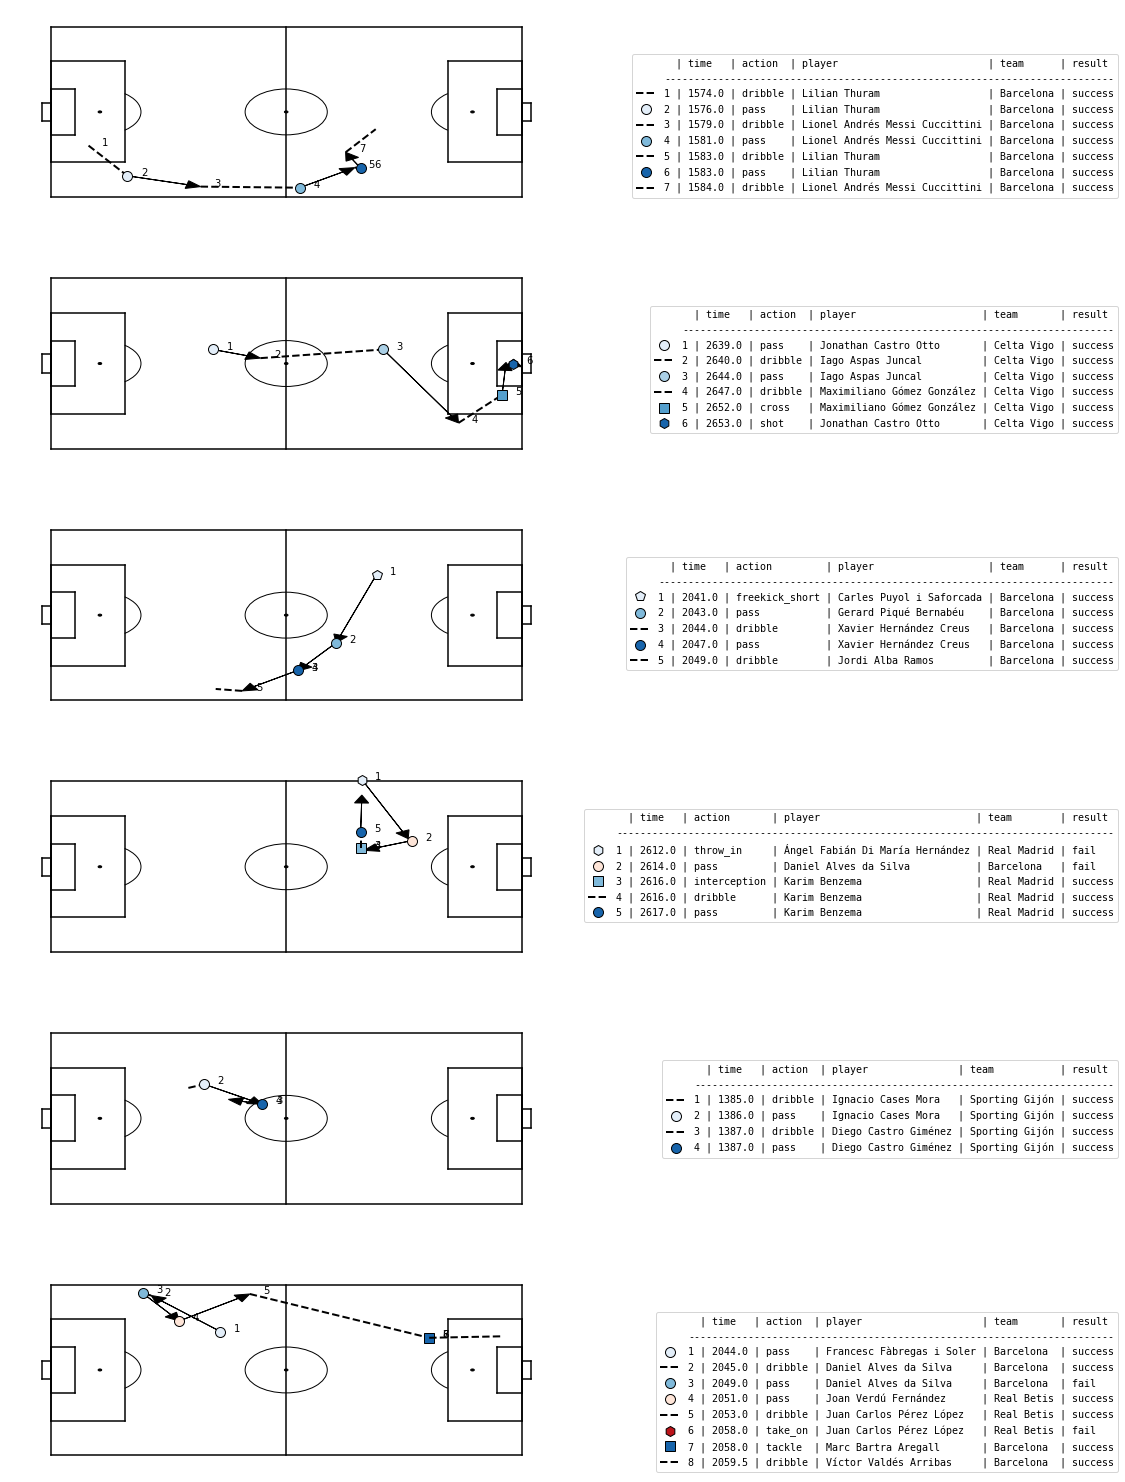

In [ ]:
## selects id
n_examples = 6
ids = lbl2ids["goal"].shuffle()[:int(n_examples/2)] + lbl2ids["no_goal"].shuffle()[:int(n_examples/2)]
play_sequences = [df_main[df_main["_id"] == _id] for _id in ids]

fig, ctxs = get_grid(n=n_examples, ncols=1, figsize= (10, 10 * 2.7), return_fig=True)
for i, ctx in enumerate(ctxs):
    play_sequence = play_sequences[i].tail(8)
    labels = play_sequence[
        ["time_seconds", "type_name", "player_name", "team_name", "result_name"]
    ]
    plot_actions(
        location=play_sequence[["start_x", "start_y", "end_x", "end_y"]],
        action_type=play_sequence.type_name,
        team=play_sequence.team_name,
        result=play_sequence.result_name,
        label=labels,
        labeltitle=["time", "action", "player", "team", "result"],
        zoom=False,
        fig=fig,
        ax=ctx,
        show_legend=True,
    )